In [3]:
import wandb 
from foundational_ssm.models import S4DNeuroModel
from foundational_ssm.utils import h5_to_dict
from foundational_ssm.data_preprocessing import smooth_spikes
import matplotlib.pyplot as plt
import torch
import os
import h5py
import pandas as pd
import numpy as np

In [4]:
api = wandb.Api()
wandb_account = "melinajingting-ucl"
project = "foundational_ssm_nlb"
run_name = "nlb_decoding_s4d_l2_d64" # Change this to the desired run name
version = "latest"

model_artifact_full_name = f"{wandb_account}/{project}/{run_name}_best_model:{version}"
model_artifact = api.artifact(model_artifact_full_name, type="model")
model_artifact_dir = model_artifact.download()

model_filename = os.path.join(model_artifact_dir, 'best_model.pt')
torch_state_dict = torch.load(model_filename)


model = S4DNeuroModel(**model_artifact.metadata)
trained_model = S4DNeuroModel(**model_artifact.metadata)
trained_model.load_state_dict(torch_state_dict)

wandb:   1 of 1 files downloaded.  


<All keys matched successfully>

In [7]:
def plot_eigenvalues_comparison(kernel, title_prefix="Eigenvalues"):
    A_real = torch.exp(kernel.log_A_real).detach().cpu().numpy()
    A_imag = kernel.A_imag.detach().cpu().numpy()
    dt = torch.exp(kernel.log_dt).detach().cpu().numpy()
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    
    for i in range(64): # State dimensions = 64
        
        # Create complex A matrix for this dimension
        A = np.zeros((32, 32), dtype=np.complex64)
        for j in range(32):
            A[j, j] = A_real[i, j] + 1j * A_imag[i, j]
        
        eigenvalues_A = np.linalg.eigvals(A)        
        dt_i = dt[i]
        eigenvalues_exp = np.exp(dt_i * eigenvalues_A)
        
        # Plot eigenvalues of A
        sc1 = axs[0].scatter(np.real(eigenvalues_A), np.imag(eigenvalues_A), 
                     alpha=0.5, s=20, c=[i]*len(eigenvalues_A))
        
        sc2 = axs[1].scatter(np.real(eigenvalues_exp), np.imag(eigenvalues_exp), 
                     alpha=0.5, s=20, c=[i]*len(eigenvalues_exp))
    
    # Plot unit circle 
    for ax, title_suffix in zip(axs, ["of A", "of exp(dt·A)"]):
        theta = np.linspace(0, 2*np.pi, 100)
        ax.plot(np.cos(theta), np.sin(theta), 'r--', alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        ax.set_xlabel("Real Part")
        ax.set_ylabel("Imaginary Part")
        ax.set_title(f"{title_prefix} {title_suffix}")
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
    
    
    plt.tight_layout()
    plt.show()

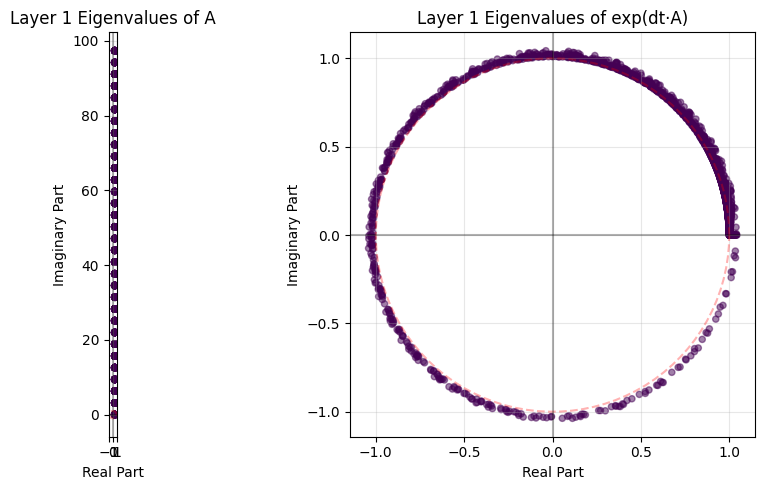

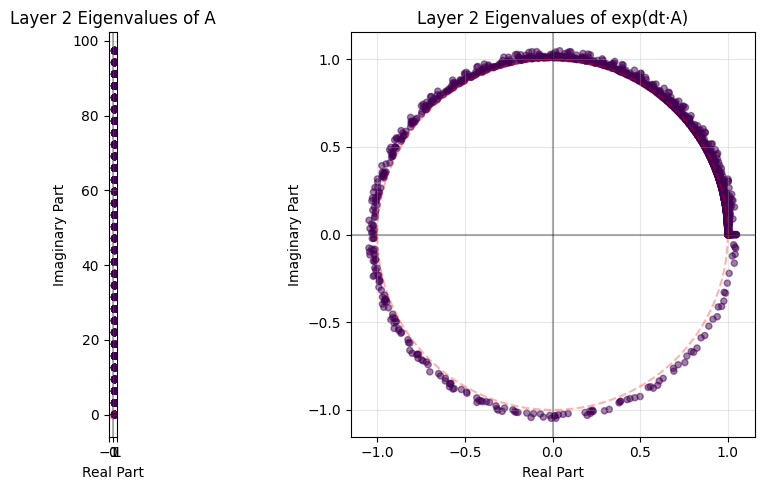

In [8]:
plot_eigenvalues_comparison(model.ssm_block[0].kernel, title_prefix="Layer 1 Eigenvalues") # 1st layer
plot_eigenvalues_comparison(model.ssm_block[1].kernel, title_prefix="Layer 2 Eigenvalues") # 2nd layer

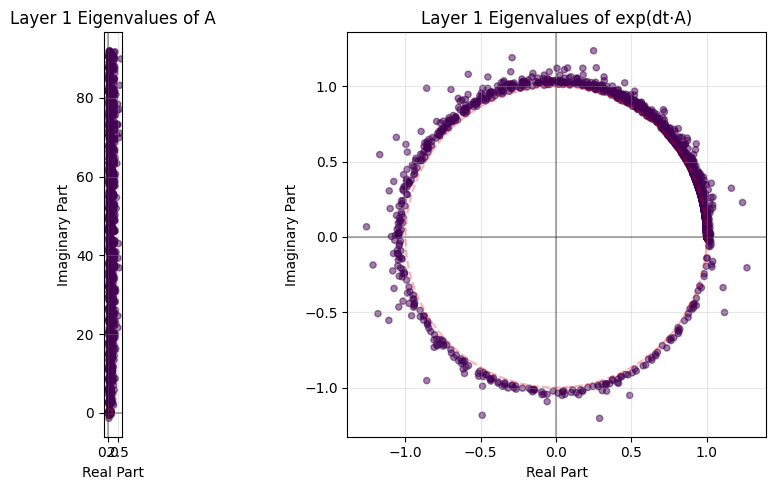

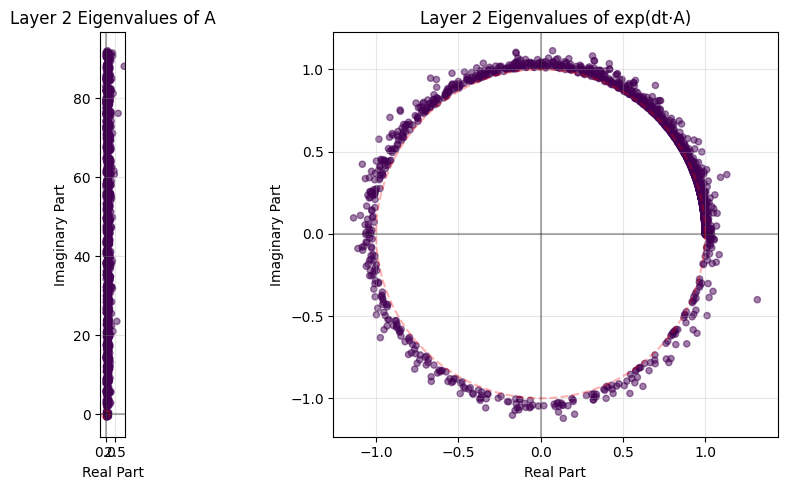

In [ ]:
plot_eigenvalues_comparison(trained_model.ssm_block[0].kernel, title_prefix="Layer 1 Eigenvalues") # 1st layer
plot_eigenvalues_comparison(trained_model.ssm_block[1].kernel, title_prefix="Layer 2 Eigenvalues") 